# 1. Imported Codebase

In [13]:
import importlib
import torch
from torch_geometric.data import DataLoader
import networkx as nx
from torch_geometric.data import Data
import time
import pickle
from torch_geometric.data import InMemoryDataset
import numpy as np
import traceback

      
    
def writeAdjacencyMatrixToDisk(G, filename='temp_adjacency_matrix.txt'):
    """
        Transform to networkx dataset

        possible formats: GML, Adjacency matrix, ..
        start by Adjcency list 
             --> (ignoring edge/node features)
             --> line format: source target target2 target3 ... 
        later we can improve this...
    """
    f = open(filename,'w')
    _ni=-1
    newline = False
    theline = []
    careturn = ""
    for ei in range(G.edge_index.size()[1]):
        if int(G.edge_index[0,ei].item()) != _ni:
            newline=True
            _ni=int(G.edge_index[0,ei].item())
            
        else:
            newline=False
            
            
        ni = str(G.edge_index[0,ei].item())
        vi = str(G.edge_index[1,ei].item())
        if newline:
            f.write(''.join(theline))
            #print(''.join(theline))
            #print(" --> "+str(_ni))
            theline =[]
            theline.append(careturn+ni+" ")
            theline.append(vi+" ")
            careturn = "\n"
        else:
            theline.append(vi+" ")
        # print("({},{})".format(ni,vi))


def pyTorchGeometricDatasetToNx(G,prefix = './temp/temp_aj_m',suffix=0):
    """
        Alternatives:
            - to disk, to nx, then dict of betweenness
            - transform in memory
            - directly pickle a G object with the betweenness
    """
    # 1. PyTorch Geometric graph -> nx -> compute betweenness 
    #             -> PyTorch Geom with target the betweenness-------
    # Transform to networkx graph
    # write to adjacency matrix on disk
    writeAdjacencyMatrixToDisk(G, filename=prefix+str(suffix)+'.txt')

    # load into a networkx graph object
    g2 = nx.read_adjlist(prefix+str(suffix)+'.txt')
    #g2 = nx_createNxGraphInMem(G)
    
    return g2


# 2. Codebase

In [147]:
import torch
from torch_geometric.data import Data 
from torch_geometric.datasets import TUDataset, QM9, QM7b, PPI, Planetoid, KarateClub
import matplotlib.pyplot as plt
import networkx as nx



def inspectGraphDataset(dataset, name):
    print("Analysis of "+name+" Dataset-----------------------------------")
    print("number of graphs in the dataset: ",len(dataset))
    print("num classes: ", dataset.num_classes)
    try:
        print("num features: ", dataset.num_features)
    except:
        pass
    
    print("\ninspecting first graph in dataset: ")
    data = dataset[0]
    print(data)
    print("data.is_undirected(): ",data.is_undirected())

    print("\ninspecting some random graph in dataset: ")
    dataset = dataset.shuffle()
    data = dataset[0]
    print(data)
    # random permutation
    # dataset = dataset.shuffle()
    # perm = torch.randperm(len(dataset))
    # dataset = dataset[perm]
    print("\n",dir(data))
    print("\n Showing some target values")
    print("num edges: ", data.num_edges)
    print("num nodes: ", data.num_nodes)
    print("contains_isolated_nodes: ", data.contains_isolated_nodes())
    print("contains_self_loops: ", data.contains_self_loops())
    print("data.is_undirected(): ",data.is_undirected())
    print("data.is_directed(): ",data.is_directed())
    print("edge_attributes: ",data.edge_attr)
    try:
        print("node features: ",data.x[0])
    except:
        pass
    print("target values: ", data.y[0])
    print("edge_index: ",data.edge_index)
    print()
    
    # transform to NX
    g = pyTorchGeometricDatasetToNx(data)
    #print(dir(g))

    # visualize
    print("\nDraw")
    if data.num_nodes < 1000:
        print(data.y[0].item())
        print(data.y[0])
        try:
            if isinstance(data.y[0].item(), int):

                attrs={}
                palette = ['yellow', 'cyan','orange','red','magenta', 'silver','grey','blue','green',   'pink','black',]


                for node in g.nodes():
                    #print(palette[color % len(palette)])
                    print(int(node))
                    print(data.y)
                    print(data.y[int(node)])
                    print(palette)
                    attrs[node]={'color':palette[data.y[int(node)] % len(palette)]}
                nx.set_node_attributes(g, attrs)
                colors = nx.get_node_attributes(g, 'color')
                nx.draw(g, node_color=colors.values())
                plt.draw()
            else:
                nx.draw(g)
                plt.draw()
        except:
            # for graph classification tasks
            nx.draw(g)
            plt.draw()
                
    else:
        print("-->too big to draw! Slicing first 300 nodes..")
        nodelist = list([ n[0] for n in g.edges()])[:300]
        #print(list(range(300)))
        g2 = g.subgraph(nodelist)
        print(g2.edges())
        nx.draw(g2)
        plt.draw()
    #print("Draw circular")
    #nx.draw_circular(g)
    #plt.draw()
    #print("Draw random")
    #nx.draw_random(g)
    #plt.draw()

Analysis of KarateClub Dataset-----------------------------------
number of graphs in the dataset:  1
num classes:  2
num features:  34

inspecting first graph in dataset: 
Data(edge_index=[2, 156], x=[34, 34], y=[34])
data.is_undirected():  True

inspecting some random graph in dataset: 
Data(edge_index=[2, 156], x=[34, 34], y=[34])

 ['__call__', '__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'apply', 'cat_dim', 'contains_isolated_nodes', 'contains_self_loops', 'contiguous', 'edge_attr', 'edge_index', 'from_dict', 'is_coalesced', 'is_directed', 'is_undirected', 'keys', 'num_edges', 'num_features', 'num_nodes

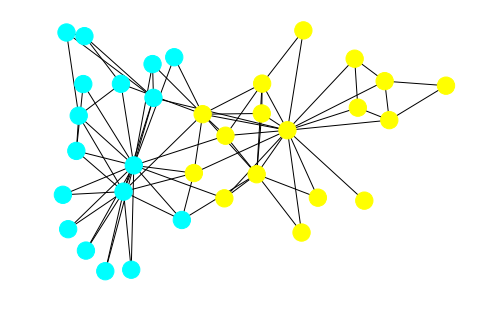

In [148]:
dataset = KarateClub()
inspectGraphDataset(dataset, 'KarateClub')

Analysis of ENZYMES Dataset-----------------------------------
number of graphs in the dataset:  600
num classes:  6
num features:  3

inspecting first graph in dataset: 
Data(edge_index=[2, 168], x=[37, 3], y=[1])
data.is_undirected():  True

inspecting some random graph in dataset: 
Data(edge_index=[2, 128], x=[29, 3], y=[1])

 ['__call__', '__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'apply', 'cat_dim', 'contains_isolated_nodes', 'contains_self_loops', 'contiguous', 'edge_attr', 'edge_index', 'from_dict', 'is_coalesced', 'is_directed', 'is_undirected', 'keys', 'num_edges', 'num_features', 'num_nodes', 'po

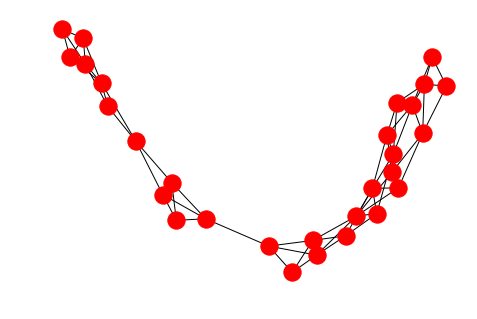

In [149]:
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
inspectGraphDataset(dataset, 'ENZYMES')

Analysis of PROTEINS Dataset-----------------------------------
number of graphs in the dataset:  1113
num classes:  2
num features:  3

inspecting first graph in dataset: 
Data(edge_index=[2, 162], x=[42, 3], y=[1])
data.is_undirected():  True

inspecting some random graph in dataset: 
Data(edge_index=[2, 138], x=[38, 3], y=[1])

 ['__call__', '__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'apply', 'cat_dim', 'contains_isolated_nodes', 'contains_self_loops', 'contiguous', 'edge_attr', 'edge_index', 'from_dict', 'is_coalesced', 'is_directed', 'is_undirected', 'keys', 'num_edges', 'num_features', 'num_nodes', '

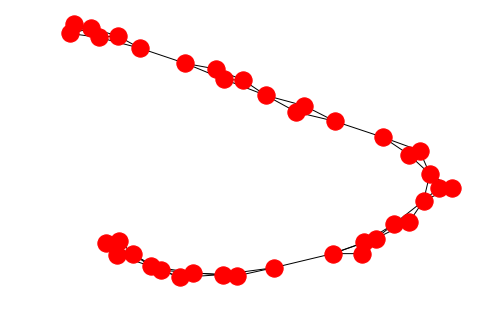

In [130]:
thename='PROTEINS'
dataset = TUDataset(root='/tmp/'+thename, name=thename)
inspectGraphDataset(dataset, thename)

Analysis of IMDB-BINARY Dataset-----------------------------------
number of graphs in the dataset:  1000
num classes:  2

inspecting first graph in dataset: 
Data(edge_index=[2, 146], y=[1])
data.is_undirected():  True

inspecting some random graph in dataset: 
Data(edge_index=[2, 74], y=[1])

 ['__call__', '__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'apply', 'cat_dim', 'contains_isolated_nodes', 'contains_self_loops', 'contiguous', 'edge_attr', 'edge_index', 'from_dict', 'is_coalesced', 'is_directed', 'is_undirected', 'keys', 'num_edges', 'num_features', 'num_nodes', 'pos', 'to', 'x', 'y']

 Showing some 

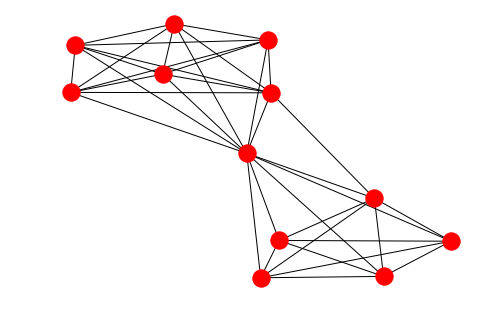

In [131]:
thename='IMDB-BINARY'
dataset = TUDataset(root='/tmp/'+thename, name=thename)
inspectGraphDataset(dataset, thename)

Analysis of REDDIT-BINARY Dataset-----------------------------------
number of graphs in the dataset:  2000
num classes:  3

inspecting first graph in dataset: 
Data(edge_index=[2, 480], y=[1])
data.is_undirected():  True

inspecting some random graph in dataset: 
Data(edge_index=[2, 2340], y=[1])

 ['__call__', '__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'apply', 'cat_dim', 'contains_isolated_nodes', 'contains_self_loops', 'contiguous', 'edge_attr', 'edge_index', 'from_dict', 'is_coalesced', 'is_directed', 'is_undirected', 'keys', 'num_edges', 'num_features', 'num_nodes', 'pos', 'to', 'x', 'y']

 Showing s

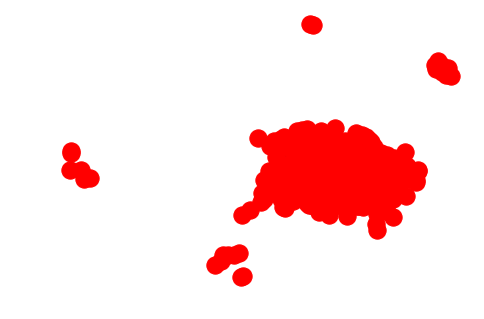

In [132]:
thename='REDDIT-BINARY'
dataset = TUDataset(root='/tmp/'+thename, name=thename)
inspectGraphDataset(dataset, thename)

Analysis of QM9 Dataset-----------------------------------
number of graphs in the dataset:  133246
num classes:  12
num features:  13

inspecting first graph in dataset: 
Data(edge_attr=[8, 4], edge_index=[2, 8], pos=[5, 3], x=[5, 13], y=[1, 12])
data.is_undirected():  True

inspecting some random graph in dataset: 
Data(edge_attr=[48, 4], edge_index=[2, 48], pos=[21, 3], x=[21, 13], y=[1, 12])

 ['__call__', '__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'apply', 'cat_dim', 'contains_isolated_nodes', 'contains_self_loops', 'contiguous', 'edge_attr', 'edge_index', 'from_dict', 'is_coalesced', 'is_directed', '

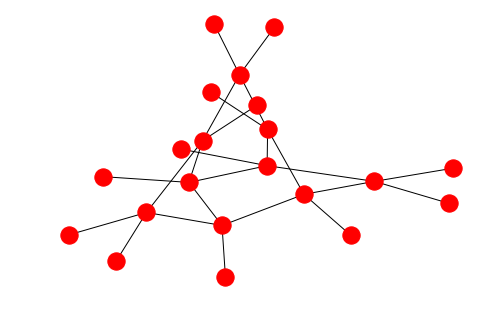

In [83]:
dataset = QM9(root='/tmp/QM9')
inspectGraphDataset(dataset, name='QM9')
# Benchmark results: MAE (Mean absolute Error)
# mu target
#    GC           0.7
#    GGNN         1.22
#    enn-s1s      0.30
#    enn-s2s-ens5 0.20
# alpha target
#    GC           2.27
#    GGNN         1.55
#    enn-s1s      0.92
#    enn-s2s-ens5 0.68
# HOMO target
#    GC           1.18
#    GGNN         1.17
#    enn-s1s      0.99
#    enn-s2s-ens5 0.87

Analysis of QM7b Dataset-----------------------------------
number of graphs in the dataset:  7211
num classes:  14

inspecting first graph in dataset: 
Data(edge_attr=[25], edge_index=[2, 25], y=[1, 14])
data.is_undirected():  True

inspecting some random graph in dataset: 
Data(edge_attr=[361], edge_index=[2, 361], y=[1, 14])

 ['__call__', '__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'apply', 'cat_dim', 'contains_isolated_nodes', 'contains_self_loops', 'contiguous', 'edge_attr', 'edge_index', 'from_dict', 'is_coalesced', 'is_directed', 'is_undirected', 'keys', 'num_edges', 'num_features', 'num_nodes', 'po

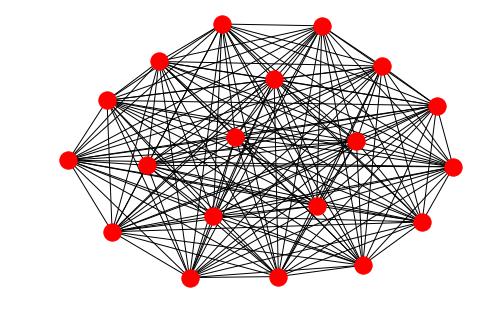

In [84]:
dataset = QM7b(root='/tmp/QM7b')
inspectGraphDataset(dataset, name='QM7b')

Analysis of PPI Dataset-----------------------------------
number of graphs in the dataset:  1
num classes:  121
num features:  50

inspecting first graph in dataset: 
Data(edge_index=[2, 818716], test_mask=[56944], train_mask=[56944], val_mask=[56944], x=[56944, 50], y=[56944, 121])
data.is_undirected():  False

inspecting some random graph in dataset: 
Data(edge_index=[2, 818716], test_mask=[56944], train_mask=[56944], val_mask=[56944], x=[56944, 50], y=[56944, 121])

 ['__call__', '__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'apply', 'cat_dim', 'contains_isolated_nodes', 'contains_self_loops', 'contiguous

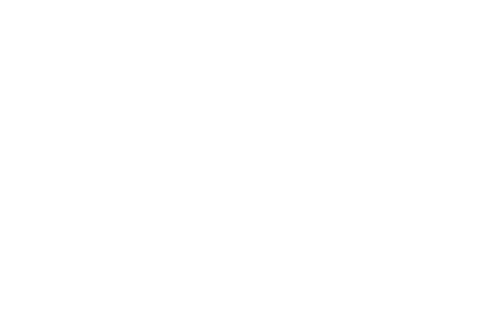

In [99]:
dataset = PPI(root='/tmp/PPI')
inspectGraphDataset(dataset, name='PPI')
# Benchmark results: F1 score
# GraphSAGE-GCN  unsup F1: 0.465, sup F1: 0.5
# GraphSAGE-mean unsup F1: 0.486, sup F1: 0.598
# GraphSAGE-LSTM unsup F1: 0.482, sup F1: 0.612
# GraphSAGE-Pool unsup F1: 0.502, sup F1: 0.6
# DeepWalk       
# Random         unsup F1: 0.396, sup F1: 0.396
# 

Analysis of Cora Dataset-----------------------------------
number of graphs in the dataset:  1
num classes:  7
num features:  1433

inspecting first graph in dataset: 
Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
data.is_undirected():  True

inspecting some random graph in dataset: 
Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

 ['__call__', '__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'apply', 'cat_dim', 'contains_isolated_nodes', 'contains_self_loops', 'contiguous', 'edge_attr', 'e

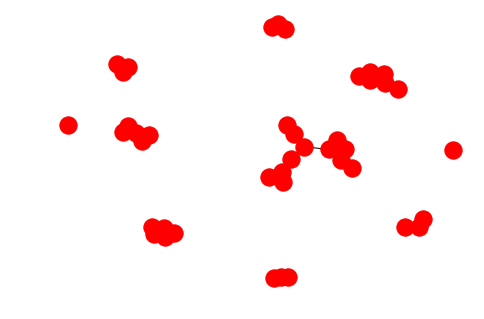

In [145]:
dataset = Planetoid(root='/tmp/Planetoid_Cora', name='Cora')
inspectGraphDataset(dataset, name='Cora')
# Benchmark results
# GCN  81.5% classification accuracy(4s)
# Planteoid 75.7%(13s)
# DeepWalk 67.2%

Analysis of Pubmed Dataset-----------------------------------
number of graphs in the dataset:  1
num classes:  3
num features:  500

inspecting first graph in dataset: 
Data(edge_index=[2, 88648], test_mask=[19717], train_mask=[19717], val_mask=[19717], x=[19717, 500], y=[19717])
data.is_undirected():  True

inspecting some random graph in dataset: 
Data(edge_index=[2, 88648], test_mask=[19717], train_mask=[19717], val_mask=[19717], x=[19717, 500], y=[19717])

 ['__call__', '__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'apply', 'cat_dim', 'contains_isolated_nodes', 'contains_self_loops', 'contiguous', 'edge_

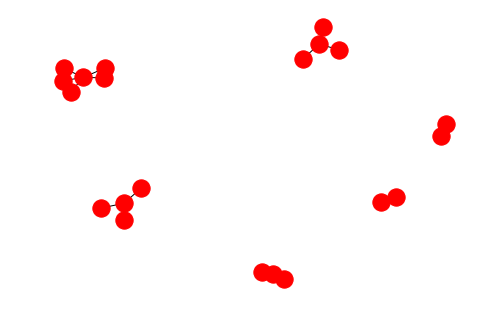

In [146]:
dataset = Planetoid(root='/tmp/Planetoid_PubMed', name='Pubmed')
inspectGraphDataset(dataset, name='Pubmed')
# Benchmark results: classification accuracy
# GCN  79.0% (38s)
# Planteoid 77.2%(25s)
# DeepWalk 65.3%